<a href="https://colab.research.google.com/github/b-irsigler/ML_MC/blob/main/causal_CNN_regressor_RayTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Regressor (RayTune)
Regressor that works on Google Colab.
Keras implementation with RayTune hyperparameter search.

## Colab warm-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/

MyDrive


In [ ]:
# needed in Colab
!pip install 'ray[tune]'

     |████████████████████████████████| 54.7 MB 37 kB/s 
     |████████████████████████████████| 72 kB 363 kB/s 
     |████████████████████████████████| 124 kB 41.0 MB/s 


## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['figure.dpi']= 200


# figsize
hor = 0.8
sc  = 1 # 0.5
plt.rcParams['figure.figsize'] = [sc*11.69,sc*8.27*hor]
prop_cycle = plt.rcParams['axes.prop_cycle']

from sklearn.model_selection import train_test_split

In [ ]:
from ray import tune
from ray.tune import JupyterNotebookReporter # CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.keras import TuneReportCallback
# https://docs.ray.io/en/latest/tune/examples/tune_mnist_keras.html

In [ ]:
# workaround needed in Colab
import os
from filelock import FileLock

## GPU Acceleration ~20x

In [ ]:
import tensorflow as tf
import timeit
# http://stackoverflow.com/questions/58947434/ddg#58956259
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError(f'GPU device not found. device={device_name}')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.657847816999947
GPU (s):
0.05828445300005569
GPU speedup over CPU: 62x


In [ ]:
!nvidia-smi

Thu Nov  4 08:20:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    60W / 149W |   4481MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Model

In [ ]:
class CausalCNNRegressor:
    
    def load(self, num_clauses, num_mc_runs, start_temperature, number,
             test_size=0.2, as_channels=True):      
        # Loads and prepares data. The path should be adjusted depending on where your 
        # data is.
        file_name = f'ec3_sim_anneal_spins{7}_clauses{num_clauses}' + \
            f'_runs{num_mc_runs}_temp{start_temperature}_{number}'
        path = f'/content/drive/MyDrive/data/raw/ec3-anneal-data_2021-10-21_1431/{file_name}.npz'
        # workaround needed in Colab
        # https://github.com/ray-project/ray/issues/5614#issuecomment-527292289
        with FileLock(os.path.expanduser("~/.data.lock")):
            data = np.load(path)
        
            ftrs = data['res_mc_timelines']
            lbls = data['res_fidelity'][:, -1]
            
            # Transformations:
            # log E
            with np.errstate(divide='ignore'):
                ftrs = np.log(ftrs)
            ftrs[np.isneginf(ftrs)]=0
            # max normalization [min,1]
            ftrs = ftrs / ftrs.max()
            # Perform min max normalization for the features [0,1]
            # ftrs = ftrs - ftrs.min()
            # ftrs /= ftrs.max() - ftrs.min()
            
            # Split train/test data for the full Hamiltonian.
            X_train, X_test, Y_train, Y_test = train_test_split(
                ftrs, lbls, test_size = test_size,)
            
            # ---------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%----------------------------
            # B, T, MC_trials -> B*MC_trials, T, 1Channel
            # tf.reshape(tf.transpose(regressor.X_train[0:2], [0,2,1]),(2*10,-1))
            if not as_channels:
                mc_trials=X_train.shape[2] # number of MC trials
                X_train_size = X_train.shape[0]*mc_trials
                X_train = np.reshape(np.transpose(X_train, [0,2,1]),(X_train_size,-1,1))
                X_test_size = X_test.shape[0]*mc_trials
                X_test = np.reshape(np.transpose(X_test, [0,2,1]),(X_test_size,-1,1))
                # B -> B*MC_trials
                Y_train = Y_train.repeat(mc_trials)
                Y_test = Y_test.repeat(mc_trials)
            # ---------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%----------------------------


            self.X_train, self.X_test = X_train, X_test 
            self.Y_train, self.Y_test = Y_train, Y_test 

    def build_model(self, learn_rate, num_conv, num_dense):
        # workaround needed in Colab
        # https://github.com/ray-project/ray/issues/5614#issuecomment-527292289
        from tensorflow import keras

        keras.backend.clear_session()
        model = keras.Sequential(name='Causal_CNN_regressor')
        # initial 1x1 conv to create channels (kind of regularization or data augmentation)
        model.add(keras.layers.Conv1D(2**7, (1,), activation = 'tanh', 
            padding = 'valid', strides = 1))
        # first conv with kernel_size=2 and normal stride so it covers everything with overlap
        model.add(keras.layers.Conv1D(2**2, (num_conv,), activation='tanh', 
            padding='valid', strides=1, ))#kernel_initializer='he_normal' ))#input_shape=(100,1)))
        # strided convs
        model.add(keras.layers.Conv1D(1, (2*num_conv,), activation='tanh', 
            padding='valid', strides=num_conv)) # overlap or not? yes, do it to learn pooling.
        model.add(keras.layers.Conv1D(1, (num_conv,), activation='tanh',
            padding='valid', strides=num_conv))
        model.add(keras.layers.Conv1D(1, (2*num_conv,), activation='elu', # last convolution with elu works well
            padding='valid', strides=num_conv))
        
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'sigmoid', 
        #     padding = 'valid', strides = 1))

        # 1x1 conv to reduce channels
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'elu', 
        #     padding = 'valid', strides = 1))
        # model.add(keras.layers.GlobalAvgPool1D(keepdims=True)) # en T

        model.add(keras.layers.Flatten()) #------------------ ----------
        
        model.add(keras.layers.Dense(num_dense, activation = 'relu'))
        # model.add(keras.layers.Dense(num_dense, activation = 'relu'))
        model.add(keras.layers.Dense(1, activation = 'sigmoid')) # to strict output in [0,1] range.
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'tanh', 
        #     padding = 'valid', strides = 1))
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'tanh', 
        #     padding = 'valid', strides = 1))
        # model.add(keras.layers.Reshape((num_dense,1)))
        # model.add(keras.layers.Conv1D(1, (4,), activation = 'tanh', 
        #     padding = 'valid', strides = 2))
        # model.add(keras.layers.Conv1D(1, (1,), activation = 'sigmoid', 
        #     padding = 'valid', strides = 1))
        # model.add(keras.layers.Flatten())
        # model.add(keras.layers.Dense(1, activation = 'sigmoid')) # to strict output in [0,1] range.

        # Tried Cyclic learning rate scheduler, no improvement in one shot.
        # BATCH_SIZE = 128
        # INIT_LR = 1e-4
        # MAX_LR = 1e-2

        # steps_per_epoch = len(self.X_train) // BATCH_SIZE
        # clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        #     maximal_learning_rate=MAX_LR,
        #     scale_fn=lambda x: 1/(2.**(x-1)),
        #     step_size=2 * steps_per_epoch
        # )
        # it is already implemented in keras:
        # decay_steps = 1000
        # initial_learning_rate = learn_rate
        # clr = tf.keras.optimizers.schedules.CosineDecay( # CosineDecayRestarts
        #     initial_learning_rate, decay_steps)
        # learn_rate = clr
        # decayed_lr = tf.keras.optimizers.schedules.ExponentialDecay(
        #     initial_learning_rate, decay_steps, decay_rate, staircase=True, name=None)


        model.compile(loss='mae',
                      optimizer=keras.optimizers.Adam(learn_rate),
                      metrics=['mae'],
                      )

        self.model = model
        
    def training(self, epochs, batch_size=128, Ray=True, keras_verbose=0, early=False):
        # Introduce early stopping
        stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
            patience = 100)

        callbacks =[]
        # Ray Tune needs some feedback from the training via the Callbacks
        if Ray:
            callbacks += [TuneReportCallback({"loss": "mae", "val_loss": "val_loss",
                                        #   "iteration": "epoch"
                                          })]
        if early:
            callbacks += [stop_early]

        self.hist = self.model.fit(self.X_train, self.Y_train, epochs = epochs,
            verbose = keras_verbose,
            validation_split = .2, batch_size = batch_size,\
            callbacks = callbacks)
        

In [ ]:
# test loading
regressor = CausalCNNRegressor()
regressor.load(5, 100, 10, 1)
regressor.X_train.shape

(8000, 100, 10)

## Test MC trials as samples data transformation

In [ ]:
print(regressor.Y_train.repeat(10)[:12])#.shape

[0.47060107 0.47060107 0.47060107 0.47060107 0.47060107 0.47060107
 0.47060107 0.47060107 0.47060107 0.47060107 0.53889091 0.53889091]


In [ ]:
np.reshape(np.transpose(regressor.X_train[0:2], [0,2,1]),(2*10,-1))

array([[0.15, 0.25, 0.15, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.1 , 0.15, ..., 0.  , 0.  , 0.  ],
       [0.05, 0.15, 0.2 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.1 , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]])

In [ ]:
print(regressor.X_train[0])

[[0.15 0.   0.05 0.   0.   0.05 0.   0.   0.15 0.1 ]
 [0.25 0.1  0.15 0.   0.   0.05 0.   0.1  0.05 0.25]
 [0.15 0.15 0.2  0.   0.   0.15 0.1  0.15 0.05 0.15]
 [0.05 0.15 0.3  0.1  0.05 0.1  0.15 0.15 0.05 0.  ]
 [0.05 0.15 0.3  0.1  0.05 0.1  0.1  0.2  0.05 0.  ]
 [0.05 0.15 0.5  0.15 0.05 0.1  0.2  0.2  0.05 0.  ]
 [0.05 0.15 0.3  0.15 0.05 0.   0.1  0.15 0.15 0.05]
 [0.   0.15 0.2  0.15 0.   0.05 0.05 0.15 0.15 0.1 ]
 [0.15 0.15 0.2  0.05 0.   0.05 0.05 0.15 0.15 0.1 ]
 [0.15 0.15 0.2  0.05 0.   0.05 0.1  0.2  0.15 0.1 ]
 [0.15 0.1  0.2  0.05 0.   0.1  0.05 0.1  0.25 0.05]
 [0.1  0.1  0.15 0.15 0.   0.1  0.05 0.2  0.3  0.05]
 [0.15 0.1  0.35 0.05 0.   0.3  0.05 0.1  0.3  0.15]
 [0.15 0.1  0.4  0.05 0.05 0.1  0.05 0.2  0.3  0.05]
 [0.1  0.1  0.35 0.   0.   0.1  0.15 0.1  0.3  0.05]
 [0.3  0.05 0.2  0.   0.1  0.1  0.05 0.15 0.35 0.05]
 [0.3  0.15 0.2  0.   0.1  0.1  0.05 0.15 0.35 0.1 ]
 [0.1  0.2  0.15 0.   0.15 0.   0.05 0.15 0.15 0.1 ]
 [0.25 0.1  0.15 0.   0.1  0.05 0.1  0.15 0.05

In [ ]:
print(tf.reshape(tf.transpose(regressor.X_train[0:2], [0,2,1]),(2*10,-1))[0])

tf.Tensor(
[0.15 0.25 0.15 0.05 0.05 0.05 0.05 0.   0.15 0.15 0.15 0.1  0.15 0.15
 0.1  0.3  0.3  0.1  0.25 0.25 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.15
 0.15 0.15 0.1  0.15 0.15 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.15
 0.15 0.15 0.   0.   0.   0.1  0.15 0.1  0.   0.   0.   0.   0.1  0.1
 0.1  0.1  0.   0.   0.   0.   0.   0.1  0.1  0.1  0.15 0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.15 0.15 0.15 0.15 0.1  0.05 0.05 0.   0.   0.   0.   0.   0.
 0.   0.  ], shape=(100,), dtype=float64)


In [ ]:
np.reshape(np.transpose(regressor.X_train[0:2], [0,2,1]),(2*10,-1))

array([[0.15, 0.25, 0.15, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.1 , 0.15, ..., 0.  , 0.  , 0.  ],
       [0.05, 0.15, 0.2 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.1 , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]])

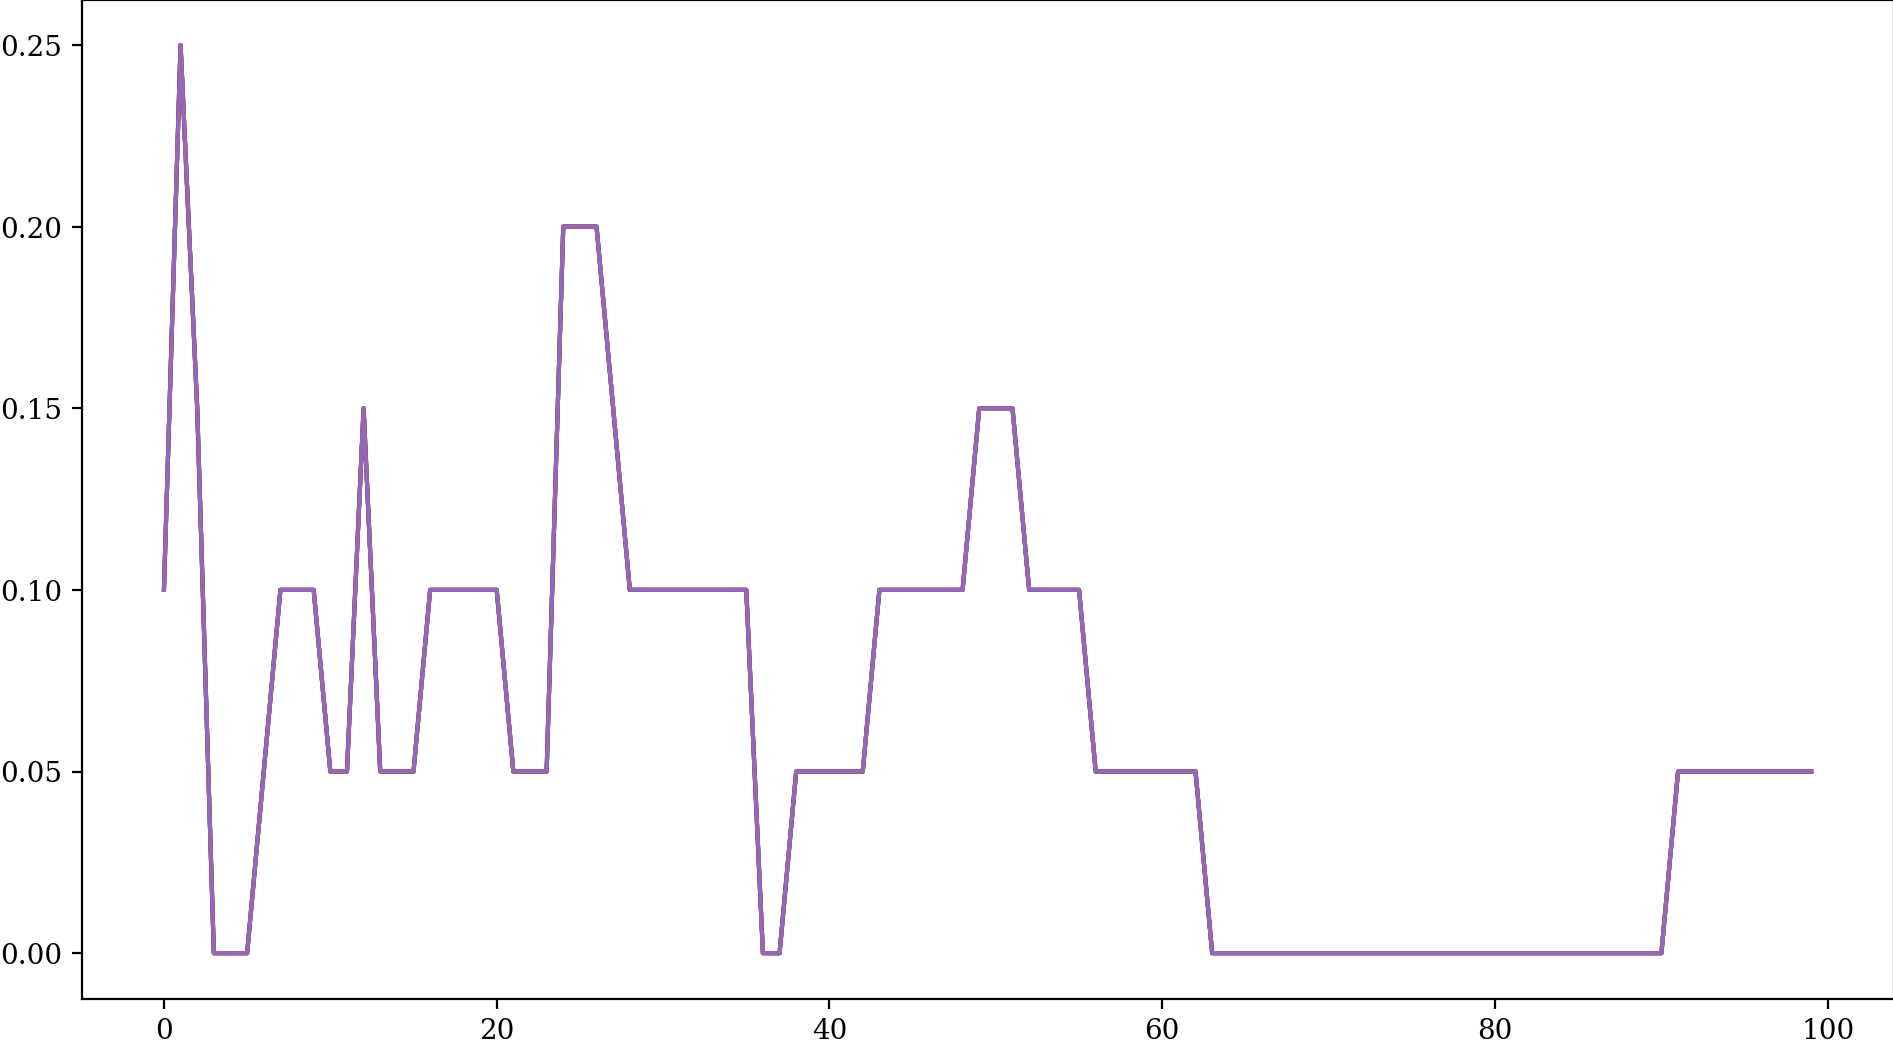

In [ ]:
idx = 9
plt.plot(regressor.X_train[0][:,idx])
plt.plot(tf.transpose(regressor.X_train[0], [1, 0])[idx])
plt.plot(tf.transpose(regressor.X_train[0:2], [0,2,1])[0,idx])
plt.plot(tf.reshape(tf.transpose(regressor.X_train[0:2], [0,2,1]),(2*10,-1))[idx]);
plt.plot(np.reshape(np.transpose(regressor.X_train[0:2], [0,2,1]),(2*10,-1))[idx]);

## Training

In [ ]:
# for Ray Tune to work the "Training" function argument should be a dictionary of variables,
# and, return nothing 
def regression(d): # previous arguments (num_clauses, num_mc_runs, start_temperature, number,
    #    lr, bsize, num_conv, num_dense,
    #    num_epochs):
    # to test GPU acceleration
    # with tf.device('/cpu:0'):
    regressor = CausalCNNRegressor()
    regressor.load(d["num_clauses"], d["num_mc_runs"], d["start_temperature"], d["number"], as_channels=d["as_channels"])
    regressor.build_model(d["lr"], d["num_conv"], d["num_dense"])
    regressor.training(d["num_epochs"], batch_size=d["bsize"], Ray=d["Ray"], keras_verbose=d["keras_verbose"])
    if not d["Ray"]:
        regressor.model.summary()
        return regressor

In [ ]:
# Test
# regressor = CausalCNNRegressor()
# regressor.load(5, 100, 10, 1)
# regressor.build_model(1e-3, 2, 16)
# regressor.training(1)
# regressor.model.summary()

In [ ]:
# with Ray Tune, regresion function changes from this
# reg = regression(5, 100, 10, 1, 1e-3, 2, 16, 200)
# reg.training(300,batch_size=2**9,Ray=False, keras_verbose=1)

In [ ]:
# to this function with dictionary input
train_args = dict(num_clauses=5, num_mc_runs=1000,
                  start_temperature=10, number=1,
                  lr=9e-4, bsize=2**9,
                  num_conv=2, num_dense=16,
                  num_epochs=150,
                  as_channels=True,
                  Ray=False, keras_verbose=1,
                  )
reg = regression(train_args)

Epoch 1/150
13/13 [==============================] - 3s 142ms/step - loss: 0.0946 - mae: 0.0946 - val_loss: 0.0920 - val_mae: 0.0920
Epoch 2/150
13/13 [==============================] - 1s 117ms/step - loss: 0.0940 - mae: 0.0940 - val_loss: 0.0919 - val_mae: 0.0919
Epoch 3/150
13/13 [==============================] - 2s 119ms/step - loss: 0.0936 - mae: 0.0936 - val_loss: 0.0913 - val_mae: 0.0913
Epoch 4/150
13/13 [==============================] - 2s 118ms/step - loss: 0.0924 - mae: 0.0924 - val_loss: 0.0895 - val_mae: 0.0895
Epoch 5/150
13/13 [==============================] - 2s 119ms/step - loss: 0.0885 - mae: 0.0885 - val_loss: 0.0833 - val_mae: 0.0833
Epoch 6/150
13/13 [==============================] - 2s 128ms/step - loss: 0.0798 - mae: 0.0798 - val_loss: 0.0745 - val_mae: 0.0745
Epoch 7/150
13/13 [==============================] - 2s 119ms/step - loss: 0.0740 - mae: 0.0740 - val_loss: 0.0706 - val_mae: 0.0706
Epoch 8/150
13/13 [==============================] - 1s 116ms/step - 

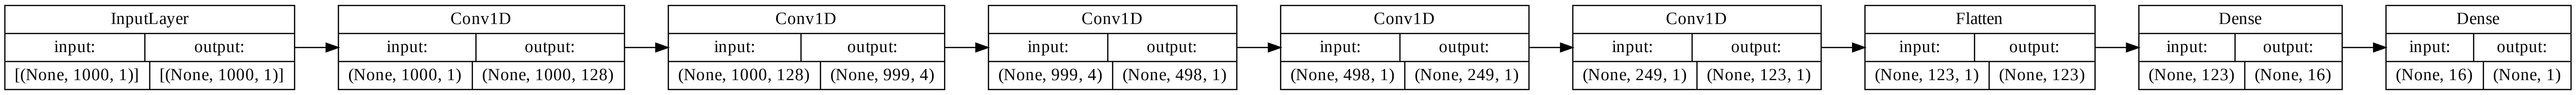

In [ ]:
tf.keras.utils.plot_model(reg.model, show_shapes=1, show_dtype=0, show_layer_names=0,
                          rankdir='LR',
                          dpi=300)

In [ ]:
reg.model.layers[0].padding,reg.model.layers[0].strides, reg.model.layers[0].dilation_rate, reg.model.layers[0].activation, reg.model.layers[0].use_bias

('valid', (1,), (1,), <function keras.activations.tanh>, True)

In [ ]:
print("kernel, stride, pad, dilation, activation, bias, init")
for l in reg.model.layers:
    if hasattr(l,'kernel_size'):
        print(l.kernel_size, l.strides, l.padding, l.dilation_rate, l.activation, l.use_bias, l.kernel_initializer)
        print(l.kernel.shape)

kernel, stride, pad, dilation, activation, bias, init
(1,) (1,) valid (1,) <function tanh at 0x7f130fd19f80> True <keras.initializers.initializers_v2.GlorotUniform object at 0x7f13008f6750>
(1, 1, 128)
(2,) (1,) valid (1,) <function tanh at 0x7f130fd19f80> True <keras.initializers.initializers_v2.GlorotUniform object at 0x7f1300826b50>
(2, 128, 4)
(4,) (2,) valid (1,) <function tanh at 0x7f130fd19f80> True <keras.initializers.initializers_v2.GlorotUniform object at 0x7f1220917ed0>
(4, 4, 1)
(2,) (2,) valid (1,) <function tanh at 0x7f130fd19f80> True <keras.initializers.initializers_v2.GlorotUniform object at 0x7f1300919410>
(2, 1, 1)
(4,) (2,) valid (1,) <function elu at 0x7f130fd197a0> True <keras.initializers.initializers_v2.GlorotUniform object at 0x7f1300919610>
(4, 1, 1)


## Plot Training Results

In [ ]:
title = f"MC EC3 N=7 m={train_args['num_clauses']} Tmc={train_args['num_mc_runs']} lr={train_args['lr']:.1g} bsize={train_args['bsize']} log(E)"
title

'MC EC3 N=7 m=5 Tmc=1000 lr=0.0009 bsize=512 log(E)'

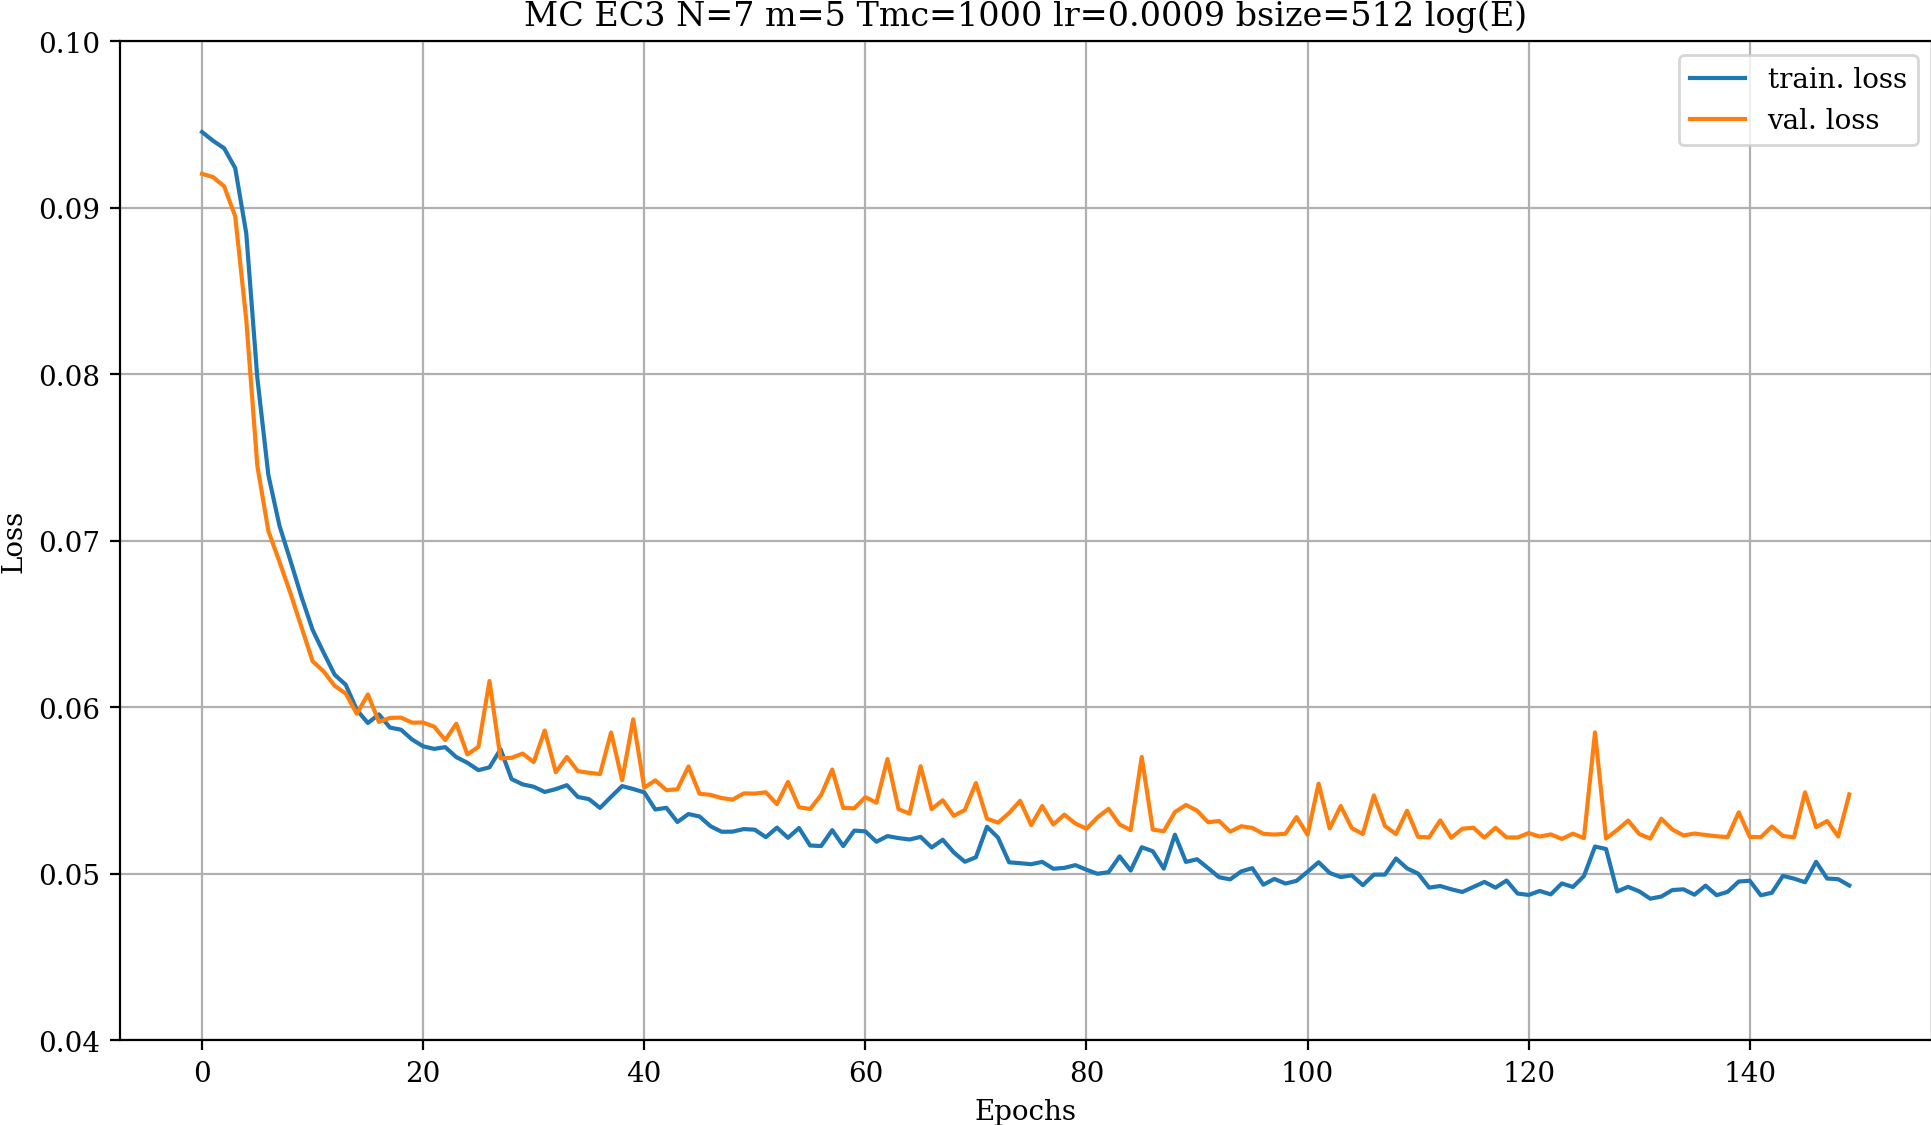

In [ ]:
plt.plot(reg.hist.history['loss'], label='train. loss')
plt.plot(reg.hist.history['val_loss'], label='val. loss')
plt.xlabel('Epochs'); plt.ylabel('Loss');
plt.title(title);
plt.grid();
plt.legend();
plt.ylim(0.040,0.100);
# plt.ylim(0.070,0.075);

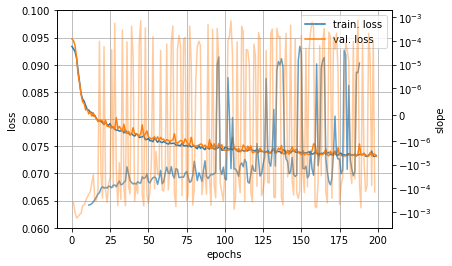

In [ ]:
plt.plot(reg.hist.history['loss'], label='train. loss')
plt.plot(reg.hist.history['val_loss'], label='val. loss')
plt.xlabel('epochs'); plt.ylabel('loss');
plt.title(title);
plt.grid();
plt.legend();
plt.ylim(0.040,0.100);

slope = (np.array(reg.hist.history['val_loss'])[2:]-np.array(reg.hist.history['val_loss'])[:-2])/3.
win = 2*10
slope_avg = np.array([slope[i:i+win].mean() for i in range(len(slope)-win)])
ax2 = plt.gca().twinx()
ax2.plot(range(1+win//2,len(reg.hist.history['val_loss'])-1-win//2),slope_avg, alpha=0.7);
ax2.plot(range(1,len(reg.hist.history['val_loss'])-1),slope, alpha=0.4);
ax2.set_ylabel('slope')
ax2.set_yscale("symlog", linthreshy=1e-6)

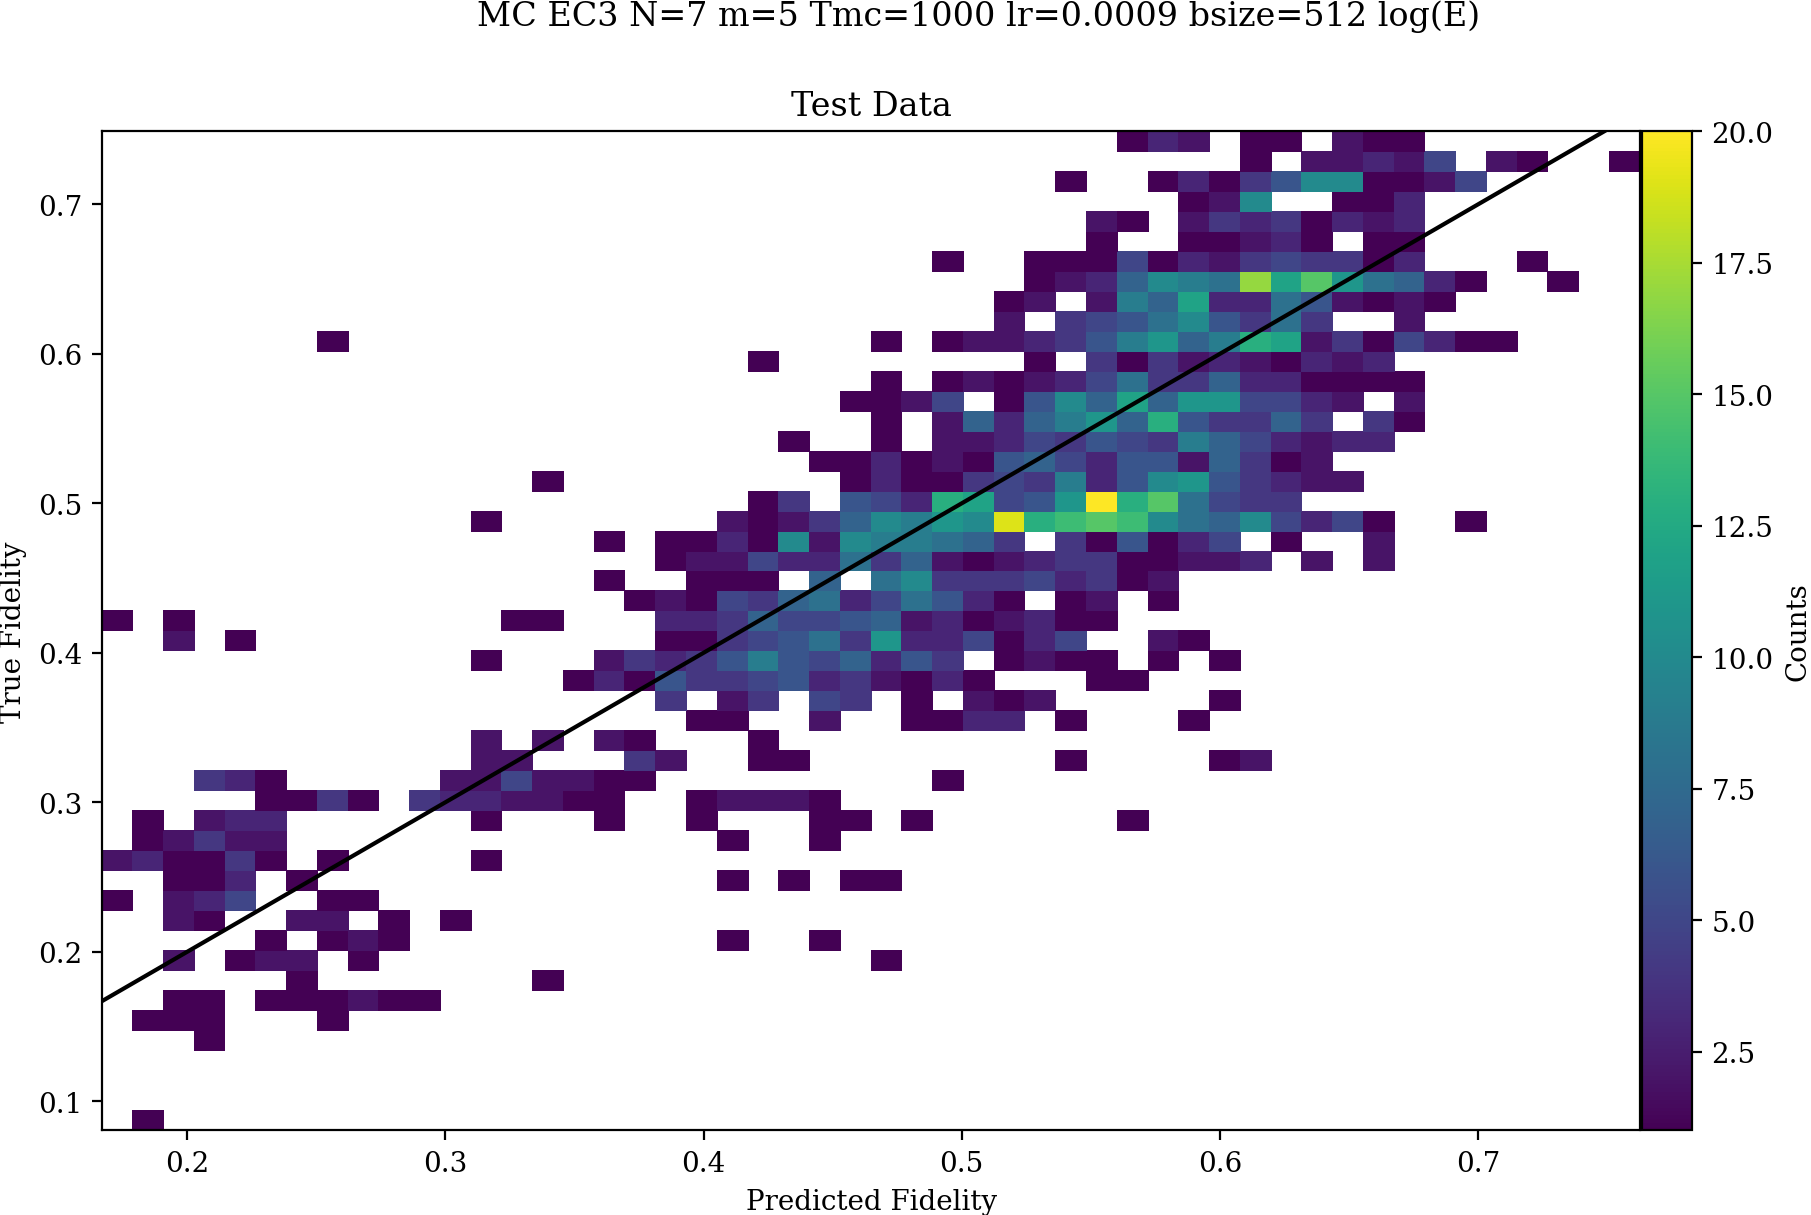

In [ ]:
h = plt.hist2d(reg.model.predict(reg.X_test).flatten(), reg.Y_test, bins=50, cmin=1,
               # norm=mpl.colors.LogNorm(),
               );
cbar = plt.colorbar(h[3], ax=plt.gca(), pad=0.001, label="Counts");
plt.plot([reg.Y_test.min(), reg.Y_test.max()], [reg.Y_test.min(), reg.Y_test.max()],'k')
plt.xlabel('Predicted Fidelity'); plt.ylabel('True Fidelity');
plt.suptitle(title);
plt.title('Test Data');

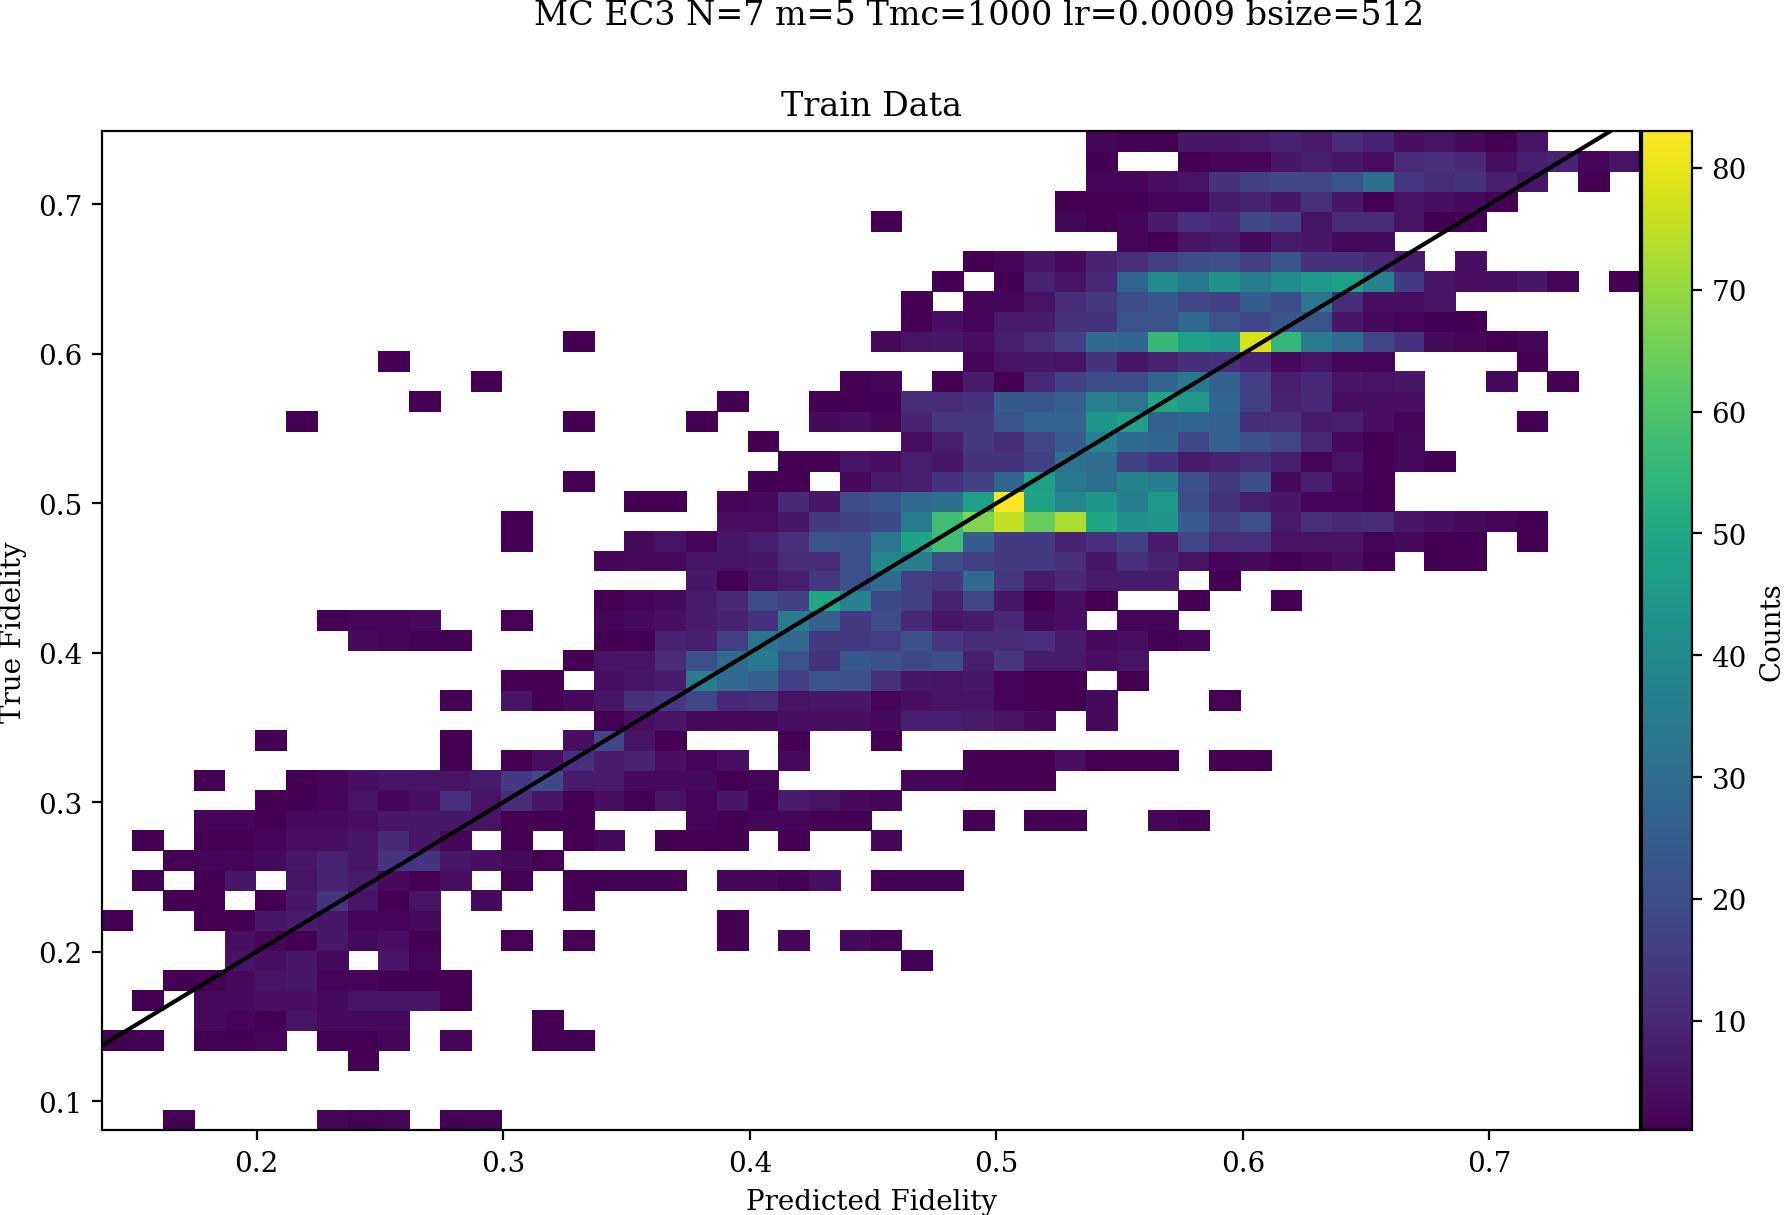

In [ ]:
h = plt.hist2d(reg.model.predict(reg.X_train).flatten(), reg.Y_train, bins=50, cmin=1,
               # norm=mpl.colors.LogNorm(),
               );
cbar = plt.colorbar(h[3], ax=plt.gca(), pad=0.001, label="Counts");
plt.plot([reg.Y_test.min(), reg.Y_test.max()], [reg.Y_test.min(), reg.Y_test.max()],'k')
plt.xlabel('Predicted Fidelity'); plt.ylabel('True Fidelity');
plt.suptitle(title);
plt.title('Train Data');

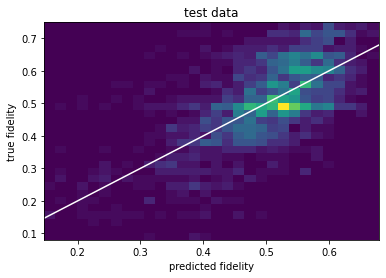

In [ ]:
plt.hist2d(reg.model.predict(reg.X_test).flatten(), reg.Y_test, bins = 30);
plt.plot([reg.Y_test.min(), reg.Y_test.max()], [reg.Y_test.min(), reg.Y_test.max()], 'w')
plt.xlabel('predicted fidelity')
plt.ylabel('true fidelity')
plt.title('test data');

## Hyperparameter Search

In [ ]:
config = {"num_clauses":5, "num_mc_runs":100,
          "start_temperature":10, "number":1,
          # random sampling by default
          "lr": tune.loguniform(5e-4, 1e-2),
          "bsize": tune.choice([2**2,2**3, 2**4,2**5,2**6,2**7,2**8]),
          "num_conv": 2,
          "num_dense":16,
          "num_epochs": 4,#150
          # custom sampling by lambda functions
          #         "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
          #         "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
          # grid search
          # "x": tune.grid_search([1, 2, 3]),
          "Ray":True,
          "keras_verbose":0,
          }
metric = "val_loss"
mode   = "min"
current_best_params = [{"lr": 1e-3,"bsize": 128,}]

In [ ]:
iter_num_epoch = 1 # how many iters per epoch
asha_scheduler = ASHAScheduler(metric=metric,mode=mode,
                            #    time_attr="iteration",
                               max_t=iter_num_epoch*300, # max time units (determined by time_attr) per trial. Can be N epochs or batches...
                               # In ASHA, you can decide how many trials are early terminated. 
                               # With grace_period=n you can force ASHA to train each trial at least for n epochs/batches/time_attr.
                               grace_period=iter_num_epoch*5,
                               # reduction_factor=20,10,4,2,1.25 means that only 5%,10%,25%,50%,80% of all trials are kept each time they are reduced.
                               reduction_factor=2)

In [ ]:
reporter_jupyter = JupyterNotebookReporter(overwrite=True, metric_columns=["loss", "val_loss", "iteration"], metric=metric,mode=mode)

In [ ]:
result = tune.run(regression, config=config,
                  #tune.with_parameters(regression, **config),
                  # name="session",
                  # partial(regression, data_dir=data_dir),
                  resources_per_trial={"cpu": 1, "gpu": 0.5}, #{"cpu": 0.5, "gpu": 0.25}, # this can create out of memory in GPUs
                  num_samples=4*1, # number of random configurations (for each grid). ex.: 10*(3x3 grid)=90 configs.
            # By default, each random variable and grid search point is sampled once. 
            # However, not all of them will run at once.
            # The max training concurrency will be the number of CPU cores on the machine you're running on. For a 2-core machine, 2 models will be trained concurrently. 
                scheduler=asha_scheduler,
#                 search_alg=search_alg,
                progress_reporter=reporter_jupyter,
                verbose=1,)

Trial name,status,loc,bsize,lr,loss,val_loss
regression_a09f2_00000,TERMINATED,172.28.0.2:3667,128,0.00201657,0.0843091,0.0827249
regression_a09f2_00001,TERMINATED,172.28.0.2:3668,4,0.00327466,0.0832384,0.0840116
regression_a09f2_00002,TERMINATED,172.28.0.2:3783,16,0.000714302,0.0820236,0.0810868
regression_a09f2_00003,TERMINATED,172.28.0.2:3869,32,0.000610408,0.090463,0.0899282


2021-11-04 08:39:57,301	INFO tune.py:630 -- Total run time: 69.99 seconds (69.81 seconds for the tuning loop).


In [ ]:
# for debugging
! cat /root/ray_results/regression_2021-11-04_08-35-11/regression_200a7_00000_0_bsize=256,lr=0.0062182_2021-11-04_08-35-11/error.txt

Failure # 1 (occurred at 2021-11-04_08-35-19)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/trial_runner.py", line 890, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/ray_trial_executor.py", line 788, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/usr/local/lib/python3.7/dist-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/ray/worker.py", line 1625, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(TuneError): ray::ImplicitFunc.train_buffered() (pid=3240, ip=172.28.0.2, repr=<types.ImplicitFunc object at 0x7ff3f6552990>)
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable.py", line 224, in train_buffered
    result = self.train()
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/t

## Plot Hypersearch Results

https://docs.ray.io/en/master/tune/api_docs/analysis.html#tune-analysis-docs

In [ ]:
from ray.tune import Analysis
# Result logdir: /root/ray_results/regression_2021-10-25_09-24-01
result = Analysis("/root/ray_results/regression_2021-10-25_09-24-01", "val_loss", "min")
best_trial_logdir = result.get_best_logdir("val_loss", "min")
print(f"Best trial config:{result.get_best_config()}")

Best trial config:{'bsize': 4, 'lr': 0.0008315204214386407, 'num_clauses': 5, 'num_conv': 2, 'num_dense': 16, 'num_epochs': 150, 'num_mc_runs': 100, 'number': 1, 'start_temperature': 10}


In [ ]:
# only for current experiment
from ray.tune import ExperimentAnalysis
# result = ExperimentAnalysis("../../ray_results/EC3_48/experiment_st
best_trial = result.get_best_trial("val_loss", "min", "all") # get_best_trial(metric, mode, scope)
# https://docs.ray.io/en/master/tune/api_docs/internals.html#trial-docstring
best_trial_logdir = best_trial.logdir
print(f"Best trial config: {best_trial.config}")

2021-10-25 10:04:09,481	WARNING experiment_analysis.py:649 -- Could not find best trial. Did you pass the correct `metric` parameter?


AttributeError: ignored

In [ ]:
if isinstance(result, ExperimentAnalysis):
    # Get a dataframe for the last reported results of all of the trials
    df_all_last = result.results_df

    # Get a list of trials
    trials = result.trials
else:
    df_all_last = result.dataframe()

In [ ]:
# works with analysis and experiment
# Get a dataframe for the min loss_test seen for each trial
df_loss_test_min = result.dataframe(metric="val_loss", mode="min")
df_loss_min = result.dataframe(metric="loss", mode="min")

# Get a dict mapping {trial logdir -> dataframes} for all trials in the experiment.
d_all = result.trial_dataframes
# In the end, it does this:
# d_all = result.fetch_trial_dataframes()

In [ ]:
df_all_last.sort_values(by=["val_loss","loss"], ascending=[1,1]).T#[25]

,13,14,11,0,1,5,4,9,12,3,8,7,6,10,2,15
loss,0.0697366,0.0701108,0.0707765,0.0747928,0.0807062,0.0826645,0.0825811,0.0883415,0.0925102,0.0934322,0.0946247,0.0926843,0.0929989,0.0941577,0.0941164,0.0924611
val_loss,0.0705841,0.072833,0.0729049,0.0742328,0.0818459,0.082108,0.0825141,0.0867349,0.0885101,0.0928613,0.0929655,0.0934749,0.0935353,0.0940735,0.0942304,0.0950073
time_this_iter_s,15.0777,1.08599,7.7055,16.223,1.1057,2.15389,0.572591,1.00183,0.595747,1.54631,7.93181,0.984774,8.21748,8.29682,1.86922,0.359983
done,False,False,False,False,True,False,False,True,True,True,False,True,True,False,False,True
timesteps_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
episodes_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
training_iteration,145,149,145,37,10,9,4,5,5,5,2,5,5,1,4,5
experiment_id,bf6f1eb66b674adbb5091d3bed28f145,203dd94ad21042feacf7d046cc2a6556,159625cda9134516ab6f06c5fd1bef3b,e99784037b114ec79f78b33334b79607,00720ce8d65a42e9bdf232c01cfa2c99,d7a333a7e3d949e5b27aa15cd6733c3e,fcf775dad998447a98d410d1c386065f,97a9d4e792e64c03ad175e8e5a832e4a,278a36807bb744daae6b5930c8bbfbae,f9dbc17e22444850bf2a950aaea0d097,ace94ce795774165a9df950fc15a940f,e6e877221c7844768b6da9ca5a7f9c98,cfa2efb45d69469fac4124ffdb424511,c8625495ee6e40c5a8af5e240731603d,7cc178ae1f9a44969c725ec8392d5230,29b1b8cf7991448a82deef1e1d32bb55
date,2021-10-25_10-01-27,2021-10-25_10-03-35,2021-10-25_09-43-28,2021-10-25_09-55-54,2021-10-25_09-57-42,2021-10-25_09-57-15,2021-10-25_09-44-37,2021-10-25_09-24-16,2021-10-25_09-57-59,2021-10-25_09-24-21,2021-10-25_09-45-25,2021-10-25_09-44-56,2021-10-25_09-58-52,2021-10-25_09-59-06,2021-10-25_09-24-40,2021-10-25_09-44-22
timestamp,1635156087,1635156215,1635155008,1635155754,1635155862,1635155835,1635155077,1635153856,1635155879,1635153861,1635155125,1635155096,1635155932,1635155946,1635153880,1635155062


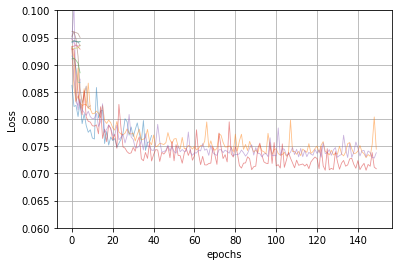

In [ ]:
ax = None
for d in d_all.values(): # plot the 3 or 4 best trials
    ax = d.val_loss.plot(ax=ax, legend=False,grid=True,
                          xlabel="epochs", ylabel="Loss",
                          alpha=0.5, #title=title,
                          style=['-'],lw=0.8,
                         );
ax.set_ylim(0.06,0.1);

In [ ]:
import matplotlib.pyplot as plt

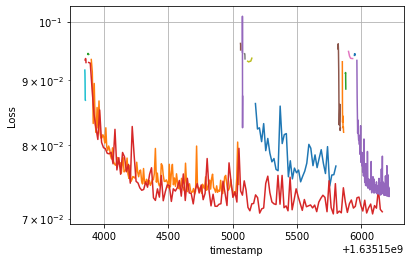

In [ ]:
# Plot by wall-clock time
ax = None
for d in d_all.values():
    ax = d.plot("timestamp", "val_loss", ax=ax, legend=False,grid=True,)
plt.yscale('log')
plt.xlabel("timestamp"); plt.ylabel("Loss");